# main

In [124]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math
import seaborn as sns


In [2]:
import metalabeller as ml
import ta

In [10]:
df = dl.get_working_data("BTCUSDT")

In [11]:
df["macd"] = ta.macd(df.close, result="hist")
df["macd_past"] = df.macd.shift(1)
df.dropna(inplace=True)
t0 = df[(df.macd<0) & (df.macd_past>0)].index
tn1 = df[(df.macd>0) & (df.macd_past<0)].index

In [14]:
tn1

DatetimeIndex(['2017-08-19 00:00:00', '2017-08-19 10:00:00',
               '2017-08-19 18:00:00', '2017-08-20 08:00:00',
               '2017-08-20 17:00:00', '2017-08-21 09:00:00',
               '2017-08-21 16:00:00', '2017-08-22 07:00:00',
               '2017-08-23 01:00:00', '2017-08-23 10:00:00',
               ...
               '2021-10-30 17:00:00', '2021-10-31 16:00:00',
               '2021-11-01 07:00:00', '2021-11-02 00:00:00',
               '2021-11-03 09:00:00', '2021-11-03 18:00:00',
               '2021-11-04 14:00:00', '2021-11-04 20:00:00',
               '2021-11-05 20:00:00', '2021-11-06 15:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=2297, freq=None)

In [18]:
t0[3]

Timestamp('2017-08-20 02:00:00')

In [30]:
tn1.searchsorted(t0, side='left', sorter=None)

array([   0,    1,    2, ..., 2294, 2295, 2296])

In [27]:
t0

DatetimeIndex(['2017-08-18 14:00:00', '2017-08-19 06:00:00',
               '2017-08-19 16:00:00', '2017-08-20 02:00:00',
               '2017-08-20 11:00:00', '2017-08-20 23:00:00',
               '2017-08-21 13:00:00', '2017-08-22 00:00:00',
               '2017-08-22 21:00:00', '2017-08-23 05:00:00',
               ...
               '2021-10-30 16:00:00', '2021-10-31 04:00:00',
               '2021-11-01 03:00:00', '2021-11-01 14:00:00',
               '2021-11-02 18:00:00', '2021-11-03 12:00:00',
               '2021-11-04 02:00:00', '2021-11-04 16:00:00',
               '2021-11-05 09:00:00', '2021-11-06 08:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=2297, freq=None)

In [31]:
a = pd.DataFrame(np.nan, index=[1,2,3], columns=["a","b"])

In [33]:
a

,a,b
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN


In [36]:
a.loc[3]={"a":5, "b":3}

In [38]:
a = [1,2,3]
dict.fromkeys(a, "4")

{1: '4', 2: '4', 3: '4'}

In [67]:
result = pd.DataFrame(np.nan, index=t0, columns=["a", "b"])

In [74]:
result.iloc[2] = {"a":3, "b":2}

In [75]:
result

,a,b
timestamp,,
2017-08-18 14:00:00,NaN,NaN
2017-08-19 06:00:00,NaN,NaN
2017-08-19 16:00:00,3.0,2.0
2017-08-20 02:00:00,NaN,NaN
2017-08-20 11:00:00,NaN,NaN
...,...,...
2021-11-03 12:00:00,NaN,NaN
2021-11-04 02:00:00,NaN,NaN
2021-11-04 16:00:00,NaN,NaN


In [102]:
def get_macd_events(df, tn1, t0, min_length=3):
    """
    returns macd events, starting at tn1 when macd crosses signal to the upside, 
    and t0 when macd crosses back down the signal. 
    df has columns [open, high, low, close, volume]
    tn1 and t0 are DatetimeIndex.
    min_length is how short a trend leg can be, in bars amount. Must be at least 3
    
    returns dataframe of events with columns
    - vdiff7: mean of volume of impulse buy divided by mean volume of last 7 days
    - vdiff30: mean of volume of impulse buy divided by mean volume of last 30 days
    - vmax: max volume hour divided by all volume in impulse buy 
    - length: number of hours of inpulse buy 
    - end: (close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback
    - h1: mean height of bars for first 1/3 of leg / mean height of bars for entire leg
    - h2: mean height of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - h3: mean height of bars for 2/3 of leg to end / mean height of bars for entire leg
    - hr7: mean heights of trend leg bars over mean heights of bars for past 7 days 
    - hr30: mean heights of trend leg bars over mean heights of bars for past 30 days 
    - v0: volume for trend leg before climax / total volume of trend leg
    - v1: volume for trend leg after climax / total volume of trend leg
    - cr: close relative: mean of all bars (close-low)/(high-low)
    - cr7: close relative over close relative for past 7 days
    - cr30: close relative over close relative over past 30 days
    - cr1: mean close of bars for first 1/3 of leg / mean height of bars for entire leg
    - cr2: mean close of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - cr3: mean close of bars for 2/3 of leg to end / mean height of bars for entire leg
    """
    stats = ["vdiff7", "vdiff30", "vmax", "length", "end", "h1", "h2", "h3", "hr7", "hr30", 
             "v0", "v1", "cr", "cr7", "cr30", "cr1", "cr2", "cr3"]
    result = pd.DataFrame(np.nan, index=t0, columns=stats)
    ls = tn1.searchsorted(t0, side='left', sorter=None)-1   # location of start (corresponding
                                                            # tn1 for t0
    for i in range(len(t0)):
        if ls[i]<0: continue 
        if tn1[ls[i]]-pd.Timedelta(days=30) not in df.index: continue
        df_ = df.loc[tn1[ls[i]]:t0[i]]
        df_7 = df.loc[tn1[ls[i]]-pd.Timedelta(days=7):t0[i]]
        df_30 = df.loc[tn1[ls[i]]-pd.Timedelta(days=30):t0[i]]
        if df_.shape[0]<min_length: continue
        row = dict.fromkeys(stats, 0.)
        
        row["vdiff7"] = (sum(df_.volume)/df_.shape[0])/(sum(df_7.volume)/df_7.shape[0])
        row["vdiff30"] = (sum(df_.volume)/df_.shape[0])/(sum(df_30.volume)/df_30.shape[0])
        row["vmax"] = get_max_vol_in_leg(df_)
        row["length"] = len(df_)
        row["end"] = get_pct_pullback(df_)
        row["h1"], row["h2"], row["h3"] = get_heights(df_)
        row["hr7"] = get_height(df_)/get_height(df_7)
        row["hr30"] = get_height(df_)/get_height(df_30)
        row["v0"], row["v1"] = get_volume_before_after(df_)
        row["cr"] = get_close_relative(df_)
        row["cr7"] = row["cr"]/get_close_relative(df_7)
        row["cr30"] = row["cr"]/get_close_relative(df_30)
        row["cr1"], row["cr2"], row["cr3"] = get_triple_close_relative(df_)

        result.iloc[i] = row
    return result.dropna()
        
        

    

In [103]:
def get_max_vol_in_leg(df):
    """returns max volume hour divided by all volume in impulse buy """
    v = max(df.volume)
    return v/sum(df.volume)

def get_pct_pullback(df):
    """(close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback"""
    return (df.iloc[-1].close-df.iloc[0].low)/(max(df.high)-df.iloc[0].low)

def get_heights(df):
    """returns ranges of the bars, over mean of all bars in the impulse buy"""
    a = int(round(df.shape[0]/3, 0))
    b = int(round(df.shape[0]*2/3, 0))
    t = get_height(df)
    return get_height(df.iloc[:a])/t, get_height(df.iloc[a:b])/t, get_height(df.iloc[b:])/t
    
def get_height(df):
    return sum(map(lambda h,l: h-l, df.high, df.low))/df.shape[0]

def get_volume_before_after(df):
    ind = list(df.high).index(max(df.high))+1
    vol = sum(df.volume)
    return sum(df.iloc[:ind].volume)/vol, sum(df.iloc[ind:].volume)/vol

def get_close_relative(df):
    """returns the mean close relative to bar for entire df. 
    Closing halfway between high and low returns 0.5"""
#     def cr(h,l,c):
#         return (c-l)/(h-l) if (h-l!= 0) else 0
    return sum(map(lambda h, l, c: (c-l)/(h-l) if (h-l!= 0) else 0, df.high, df.low, df.close))/df.shape[0]

def get_triple_close_relative(df):
    """
    returns close relative for third segments of df over total
    """
    t = get_close_relative(df)
    a = int(round(df.shape[0]/3, 0))
    b = int(round(df.shape[0]*2/3, 0))
    return get_close_relative(df.iloc[:a])/t, get_close_relative(df.iloc[a:b])/t, get_close_relative(df.iloc[b:])/t

In [104]:
result = get_macd_events(df, tn1, t0, min_length=3)

In [105]:
result

,vdiff7,vdiff30,vmax,length,end,h1,h2,h3,hr7,hr30,v0,v1,cr,cr7,cr30,cr1,cr2,cr3
timestamp,,,,,,,,,,,,,,,,,,
2017-09-17 23:00:00,0.555802,0.743053,0.196159,12.0,0.806485,1.222422,0.961422,0.816156,0.632970,0.726952,0.713965,0.286035,0.546674,1.111972,1.127329,1.255773,0.907026,0.837202
2017-09-18 10:00:00,0.986376,1.366572,0.210423,9.0,0.745022,1.011949,1.197375,0.790675,0.922223,1.066377,0.721690,0.278310,0.617323,1.239021,1.271480,0.984730,1.158526,0.856744
2017-09-18 15:00:00,1.492564,2.077489,0.298892,4.0,0.601758,1.458956,0.764102,1.012841,1.251079,1.453041,0.475317,0.524683,0.526102,1.051909,1.082063,1.546703,0.570780,1.311737
2017-09-19 15:00:00,0.738791,1.030378,0.187059,8.0,0.578606,1.107597,0.833749,1.003237,0.715543,0.844987,0.422893,0.577107,0.542485,1.098039,1.124451,1.146022,0.864955,0.944008
2017-09-19 19:00:00,0.607697,0.844276,0.361832,4.0,-1.018966,0.574301,0.954874,1.515951,0.620294,0.738524,0.474822,0.525178,0.214752,0.443921,0.448079,1.132466,1.005695,0.856144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 12:00:00,0.953273,0.833429,0.440573,4.0,-0.765939,0.962329,0.603244,1.831183,0.834597,0.824050,0.368380,0.631620,0.474800,0.950930,0.917422,1.815262,0.809530,0.565677
2021-11-04 02:00:00,1.064004,0.925047,0.380353,9.0,0.731547,1.712692,0.667673,0.619634,1.195654,1.192802,0.485612,0.514388,0.448291,0.895402,0.871132,0.793559,1.182423,1.024018
2021-11-04 16:00:00,1.404613,1.195920,0.496570,3.0,-0.664123,0.961593,1.390514,0.647894,1.262588,1.242666,0.212811,0.787189,0.371399,0.750840,0.724265,0.414700,0.669173,1.916127


In [126]:
## Temp filtering:
result = result[result.end>0.5]
result = result[result.vdiff7>1.5]
result = result[result.hr7>1.5]

In [139]:
result.tail()

,vdiff7,vdiff30,vmax,length,end,h1,h2,h3,hr7,hr30,v0,v1,cr,cr7,cr30,cr1,cr2,cr3
timestamp,,,,,,,,,,,,,,,,,,
2021-02-09 03:00:00,2.002812,1.778126,0.305032,5.0,0.690393,1.342457,0.739464,0.787811,2.125386,1.764694,0.583679,0.416321,0.529913,0.980756,1.018484,1.162280,0.676751,0.999344
2021-07-26 08:00:00,2.184332,2.226692,0.278235,15.0,0.704859,0.299901,1.772172,0.927927,2.244189,2.080883,0.562144,0.437856,0.628710,1.225953,1.230394,1.036951,1.122508,0.840542
2021-08-06 00:00:00,1.838768,1.883221,0.148811,11.0,0.629929,1.344906,0.840878,0.774435,1.666506,1.980134,0.740696,0.259304,0.539966,1.061290,1.068718,1.461046,0.854078,0.648395
2021-10-06 20:00:00,2.291047,2.193301,0.307478,9.0,0.851749,1.759151,0.634329,0.606521,2.031292,1.947387,0.476637,0.523363,0.590479,1.092977,1.131714,1.328460,0.960128,0.711412
2021-10-15 22:00:00,1.626213,1.863891,0.238800,8.0,0.505679,1.006705,0.414465,1.383652,1.617399,1.767417,0.827550,0.172450,0.600957,1.109496,1.153391,1.470348,0.730904,0.709049


In [19]:
a = df.to_numpy()

In [28]:
ma = df.open.rolling(window=10000).mean().diff()

In [107]:
def find_pivots(df, unit = 1000):
    """returns timestamps of peaks"""
    i = 0
    price = df.open.to_list()
    timestamps = df.timestamp.to_list()
    h_ts = [] #high timestamps
    l_ts = []
    past = price[0]
    now = price[0]
    future = price[unit]
    while True:
        if now>past and now>future:
            h_ts.append(timestamps[i])
        elif now<past and now<future:
            l_ts.append(timestamps[i])
        i += unit
        past = now
        now = future
        try:
            future = price[i+unit]
        except:
            break
    return h_ts, l_ts
                

In [112]:
h, l = find_pivots(df)

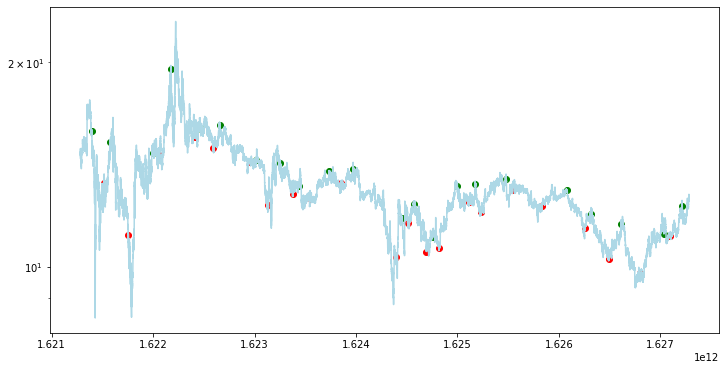

In [113]:

fig, ax = plt.subplots(figsize=(12, 6))
plotdf = df[-200000:-100000]
h = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, h))
l = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, l))

plt.yscale("log")
ax.plot(plotdf.set_index("timestamp").open, c="lightblue")
ax.scatter(h, plotdf.set_index("timestamp").reindex(h)["open"], c="green")
ax.scatter(l, plotdf.set_index("timestamp").reindex(l)["open"], c="red")

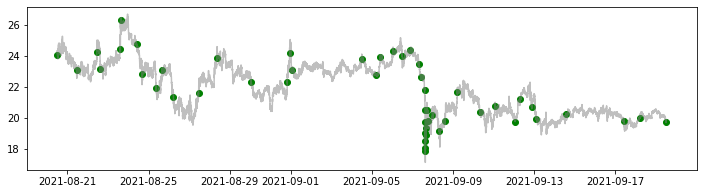

In [8]:
t_range = t_events[-100:-50]
fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(t_range, df.reindex(t_range).open, c="green")
ax.plot(df[(df.index>t_range[0]) & (df.index<t_range[-1])].open, c="gray", alpha=0.5)

In [128]:
t_events = result.index

In [129]:
vol = ml.get_daily_vol(df.close)
# t_events = ml.get_t_events(df.close, vol, 0.02)
t1 = ml.get_vertical_barrier(df.close, t_events, 2)

verify that get_vertical_barrier works as expected, use above code
remove above remove duplicates code with BTC data and see if it works


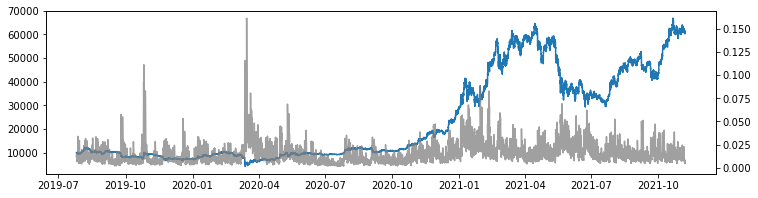

In [130]:
a = [-20000, -1]
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df.open[a[0]:a[1]])
ax1 = ax.twinx()
ax1.plot(vol[a[0]:a[1]], c="gray", alpha=0.75)

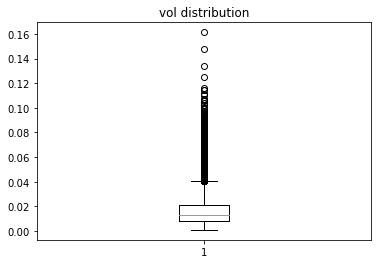

In [131]:
fig, ax = plt.subplots()
ax.set_title('vol distribution')
ax.boxplot(list(vol.dropna()))
plt.show()

In [132]:
side = pd.Series(np.random.randint(0, 2, len(t_events)), index=t_events)

In [8]:
ind = list(t1.index)
val = list(t1)
new = []
for i in range(len(ind)):
    new.append(val[i]-ind[i])

<AxesSubplot:>

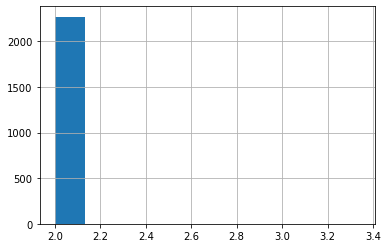

In [10]:
a = t1.index.values
new = (t1.loc[a]-a)/(60000*24*60)
new.hist()

In [133]:
# create target series
ptsl = [1,1]
min_ret = 0.00
    
# events = ml.get_events(df.open,t_events,ptsl,vol,min_ret,1,t1=t1,side=side)
events = ml.get_events(df.open,t_events,ptsl,vol,min_ret,1,t1=t1,side=pd.Series(1.,index=t_events))

events

,t1,trgt,side
timestamp,,,
2017-10-12 17:00:00,2017-10-13 02:00:00,0.029180,1.0
2017-10-20 22:00:00,2017-10-21 16:00:00,0.028066,1.0
2017-11-29 16:00:00,2017-11-29 18:00:00,0.034319,1.0
2018-01-18 04:00:00,2018-01-18 15:00:00,0.058050,1.0
2018-04-12 19:00:00,2018-04-13 08:00:00,0.041659,1.0
...,...,...,...
2021-02-09 03:00:00,2021-02-11 03:00:00,0.059990,1.0
2021-07-26 08:00:00,2021-07-26 19:00:00,0.029191,1.0
2021-08-06 00:00:00,2021-08-06 16:00:00,0.026887,1.0


TypeError: The DTypes <class 'numpy.dtype[float64]'> and <class 'numpy.dtype[timedelta64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

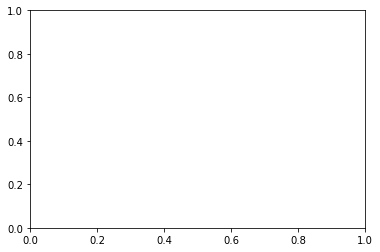

In [116]:
a = events.index.values
new = (events.loc[a].t1 - a)/(60000*24*60)
new.hist()

In [134]:
labels = ml.get_bins(events, df.close, t1)

In [135]:
labels

,ret,target
timestamp,,
2017-10-12 17:00:00,0.065140,1.0
2017-10-20 22:00:00,0.020786,1.0
2017-11-29 16:00:00,-0.057367,0.0
2018-01-18 04:00:00,0.086655,1.0
2018-04-12 19:00:00,0.056235,1.0
...,...,...
2021-02-09 03:00:00,-0.043293,0.0
2021-07-26 08:00:00,0.030652,1.0
2021-08-06 00:00:00,0.061353,1.0


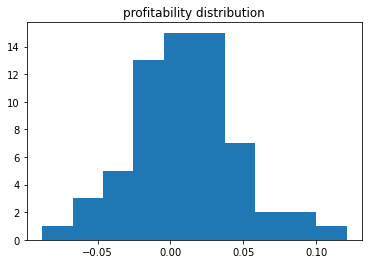

In [136]:
fig, ax = plt.subplots()
ax.set_title('profitability distribution')
ax.hist(labels.ret)
plt.show()

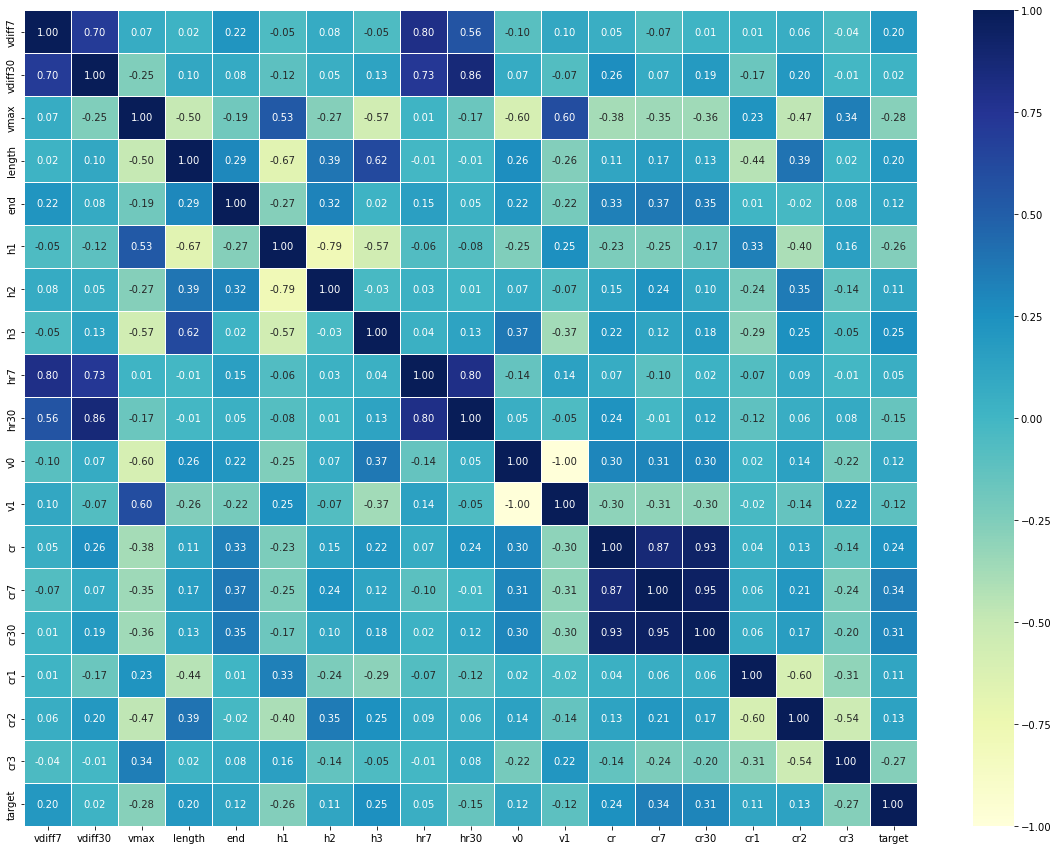

In [137]:
indicators = list(result.columns)
indicators.append("target")

# d = df[list(indicators)].copy()
d = result.copy()
d["target"] = labels.target
corr_matrix = d.corr()
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")

    - vdiff7: mean of volume of impulse buy divided by mean volume of last 7 days
    - vdiff30: mean of volume of impulse buy divided by mean volume of last 30 days
    - vmax: max volume hour divided by all volume in impulse buy 
    - length: number of hours of inpulse buy 
    - end: (close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback
    - h1: mean height of bars for first 1/3 of leg / mean height of bars for entire leg
    - h2: mean height of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - h3: mean height of bars for 2/3 of leg to end / mean height of bars for entire leg
    - hr7: mean heights of trend leg bars over mean heights of bars for past 7 days 
    - hr30: mean heights of trend leg bars over mean heights of bars for past 30 days 
    - v0: volume for trend leg before climax / total volume of trend leg
    - v1: volume for trend leg after climax / total volume of trend leg
    - cr: close relative: mean of all bars (close-low)/(high-low)
    - cr7: close relative over close relative for past 7 days
    - cr30: close relative over close relative over past 30 days
    - cr1: mean close of bars for first 1/3 of leg / mean height of bars for entire leg
    - cr2: mean close of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - cr3: mean close of bars for 2/3 of leg to end / mean height of bars for entire leg

In [14]:
lookback = 4000
def get_z_score(a, b):
    """Returns the latest zscore between dataframes a and b. IF NAN, RETURN PREVIOUS"""
    a = a.set_index("timestamp") #Do not set inplace cause reference
    b = b.set_index("timestamp")

    df = pd.to_numeric(a.open.rename("A")).to_frame()
    df["B"] = pd.to_numeric(b.open)

    df.dropna(inplace=True)

    results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
    hr = results.params[1]
    spread = pd.Series((df['B'] - hr * df['A'])).rename("spread").to_frame()
    spread["mean"] = spread.spread.rolling(lookback).mean()
    spread["std"] = spread.spread.rolling(lookback).std()
    spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
    return get_non_nan_zscore(spread)    
    
def get_non_nan_zscore(spread):
    """loops through spread finding latest non-nan zscore"""
    zscore = spread.iloc[-1].zscore
    i = 2
    while math.isnan(zscore):
        zscore = spread.iloc[-i].zscore
        i += 1
    return zscore

In [10]:
a = dl.get_minutely_data("HNTUSDT", past=False)
b = dl.get_minutely_data("BTCUSDT", past=False)

In [17]:
z = get_z_score(a, b)

In [18]:
z

-0.15050287861225423